# Preprocessing And Model Training

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
df = pd.read_csv('./dataset/feature_ready.csv')
df.head()

,Income,TotalSpend,Recency,CustomerTenure,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,TotalChildren
0,58138.0,1617,58,13.32,3,7,8,10,4,0
1,46344.0,27,38,11.82,2,5,1,1,2,2
2,71613.0,776,26,12.36,1,4,8,2,10,0
3,26646.0,53,26,11.89,2,6,2,0,4,1
4,58293.0,422,94,11.95,5,5,5,3,6,1


In [4]:
X = df.copy()
outlier_cols = ["Income","TotalSpend","NumDealsPurchases","NumWebVisitsMonth","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]

for col in outlier_cols:
    lower = X[col].quantile(0.01)
    upper = X[col].quantile(0.99)
    X[col] = X[col].clip(lower, upper)


In [6]:
for col in outlier_cols:
    X[col] = np.log1p(X[col])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
joblib.dump(scaler,'models/scaler.pkl')

['models/scaler.pkl']

In [14]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2240.0,-3.727177e-17,1.000223,-3.733127,-0.572156,0.204633,0.778486,1.448875
TotalSpend,2240.0,8.168069e-17,1.000223,-2.040212,-0.942139,0.247013,0.909799,1.394791
Recency,2240.0,-3.172066e-18,1.000223,-1.696001,-0.867157,-0.003777,0.859602,1.722981
CustomerTenure,2240.0,-1.836626e-15,1.000223,-1.744337,-0.859140,0.007992,0.875124,1.706125
NumDealsPurchases,2240.0,-2.854859e-16,1.000223,-2.315266,-0.824460,0.047606,0.666346,2.842075
NumWebVisitsMonth,2240.0,1.490871e-16,1.000223,-2.350882,-0.811085,0.432078,0.728712,1.224416
NumWebPurchases,2240.0,1.633614e-16,1.000223,-2.644358,-0.676094,0.239097,0.841917,1.807579
NumCatalogPurchases,2240.0,-1.570173e-16,1.000223,-1.309266,-1.309266,0.123383,0.789527,1.888099
NumStorePurchases,2240.0,3.013462e-17,1.000223,-1.529201,-0.910144,-0.037632,0.834880,1.785651
TotalChildren,2240.0,4.123686e-17,1.000223,-1.264505,-1.264505,0.065928,0.065928,2.726794


### Choosing optimal number of Clusters

In [15]:
from sklearn.cluster import KMeans

``` 1. Elbow Method ```

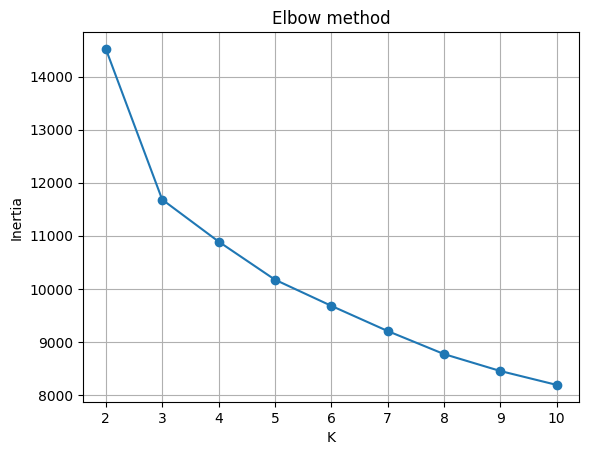

In [24]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=42,n_init=10)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.grid(True)
plt.show()


```2. Silhouette Score ```

In [ ]:
from sklearn.metrics import silhouette_score

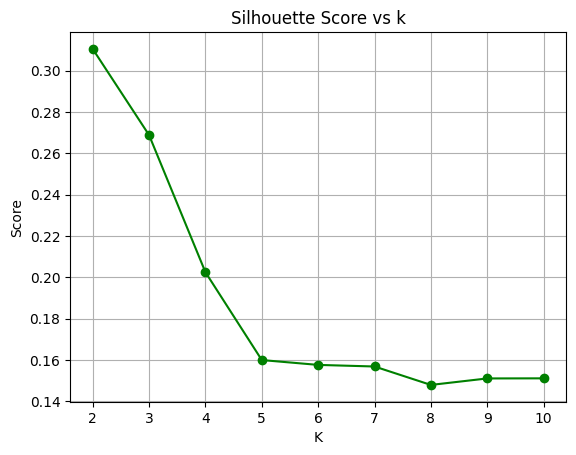

In [23]:
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=42,n_init=10)
    labels = kmeans.fit_predict(X_scaled_df)
    score = silhouette_score(X_scaled_df, labels)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.xlabel("K")
plt.ylabel("Score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()


### ``` K=4 ``` This seems the sweet spot with minimal dimninshing in inertia and a good sillhouette score.

In [25]:
kmeans = KMeans(n_clusters=4,random_state=42,n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled_df)
cluster_labels

array([0, 3, 1, ..., 1, 1, 0], shape=(2240,), dtype=int32)

In [27]:
df_cluster = df.copy()
df_cluster['Cluster'] = cluster_labels
df_cluster.head()

,Income,TotalSpend,Recency,CustomerTenure,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,TotalChildren,Cluster
0,58138.0,1617,58,13.32,3,7,8,10,4,0,0
1,46344.0,27,38,11.82,2,5,1,1,2,2,3
2,71613.0,776,26,12.36,1,4,8,2,10,0,1
3,26646.0,53,26,11.89,2,6,2,0,4,1,3
4,58293.0,422,94,11.95,5,5,5,3,6,1,0


In [51]:
customer_percentage = df_cluster["Cluster"].value_counts(normalize=True) * 100

### Cluster Interpretation


- PCA Projection

In [32]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_df)
pca_df = df_cluster.copy()
pca_df["PCA1"] = X_pca[:, 0]
pca_df["PCA2"] = X_pca[:, 1]

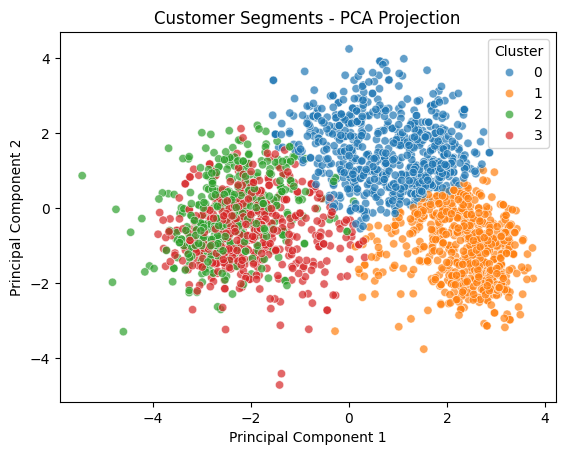

In [39]:
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="Cluster",palette="tab10",alpha=0.7)
plt.title("Customer Segments - PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

- Income vs Spend based on clusters Analysis

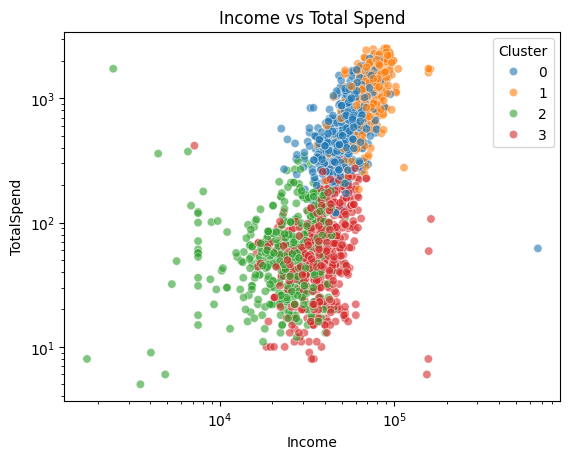

In [44]:
sns.scatterplot(data=df_cluster,x="Income",y="TotalSpend",hue="Cluster",palette="tab10",alpha=0.6)
plt.title("Income vs Total Spend")
plt.xscale("log")
plt.yscale("log")
plt.show()

- Recency vs Total Spend per Cluster Analysis

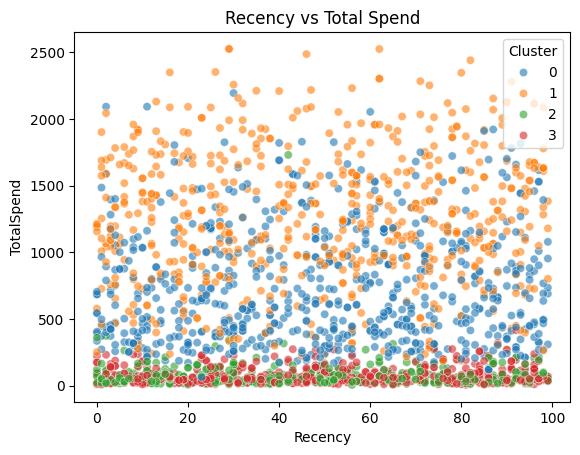

In [46]:
sns.scatterplot(data=df_cluster,x="Recency",y="TotalSpend",hue="Cluster",palette="tab10",alpha=0.6)
plt.title("Recency vs Total Spend")
plt.show()

- Purchase channel for each Cluster

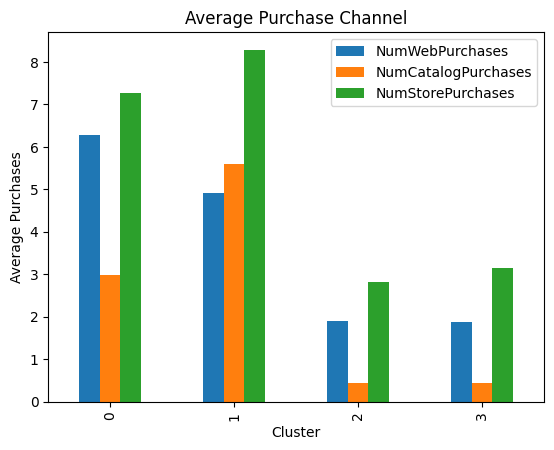

In [48]:
channel_means = (df_cluster.groupby("Cluster")[["NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]].mean())

channel_means.plot(kind="bar")
plt.title("Average Purchase Channel")
plt.ylabel("Average Purchases")
plt.show()


In [49]:
cluster_profile = (df_cluster.groupby("Cluster").agg({
        "Income": "mean",
        "TotalSpend": "mean",
        "Recency": "mean",
        "CustomerTenure": "mean",
        "NumDealsPurchases": "mean",
        "NumWebVisitsMonth": "mean",
        "NumWebPurchases": "mean",
        "NumCatalogPurchases": "mean",
        "NumStorePurchases": "mean",
        "TotalChildren": "mean"
    }))

cluster_profile


,Income,TotalSpend,Recency,CustomerTenure,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,TotalChildren
Cluster,,,,,,,,,,
0,56978.428017,729.439942,49.574530,12.731693,3.985528,6.260492,6.277858,2.976845,7.260492,1.227207
1,74507.324935,1252.844551,48.924679,12.371442,1.165064,2.596154,4.913462,5.600962,8.285256,0.222756
2,25945.592205,77.146572,46.508274,12.765957,1.943262,7.397163,1.910165,0.444444,2.832151,0.945626
3,40227.476117,76.766932,50.890438,12.007789,1.802789,5.645418,1.868526,0.444223,3.157371,1.478088


In [52]:
cluster_profile["Customer_%"] = customer_percentage
cluster_profile

,Income,TotalSpend,Recency,CustomerTenure,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,TotalChildren,Customer_%
Cluster,,,,,,,,,,,
0,56978.428017,729.439942,49.574530,12.731693,3.985528,6.260492,6.277858,2.976845,7.260492,1.227207,30.848214
1,74507.324935,1252.844551,48.924679,12.371442,1.165064,2.596154,4.913462,5.600962,8.285256,0.222756,27.857143
2,25945.592205,77.146572,46.508274,12.765957,1.943262,7.397163,1.910165,0.444444,2.832151,0.945626,18.883929
3,40227.476117,76.766932,50.890438,12.007789,1.802789,5.645418,1.868526,0.444223,3.157371,1.478088,22.410714


### Tagging the clusters with their respective suited profiles.

In [55]:
cluster_names = {0: "High value loyal customers",1: "Deal driven customers",2: "Family budget customers",3: "At risk customers"}

df_cluster["ClusterName"] = df_cluster["Cluster"].map(cluster_names)
df_cluster.head()

,Income,TotalSpend,Recency,CustomerTenure,NumDealsPurchases,NumWebVisitsMonth,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,TotalChildren,Cluster,ClusterName
0,58138.0,1617,58,13.32,3,7,8,10,4,0,0,High value loyal customers
1,46344.0,27,38,11.82,2,5,1,1,2,2,3,At risk customers
2,71613.0,776,26,12.36,1,4,8,2,10,0,1,Deal driven customers
3,26646.0,53,26,11.89,2,6,2,0,4,1,3,At risk customers
4,58293.0,422,94,11.95,5,5,5,3,6,1,0,High value loyal customers


### Downloading the Model for further inference

In [57]:
joblib.dump(kmeans,'./models/kmeans.pkl')

['./models/kmeans.pkl']

In [64]:
df2 = pd.read_csv('./dataset/reduced_columns.csv')
df_cluster['TotalPurchases'] = df2['TotalPurchases']
df_cluster.to_csv('./dataset/Clustered_df.csv',index=False)

In [61]:
pca_df = pd.DataFrame(X_pca,columns=["PC1", "PC2"])
pca_df["Cluster"] = df_cluster["Cluster"].values
pca_df.to_csv("./dataset/pca_2d.csv",index=False)
